C:\Users\samue\anaconda3\envs\venv_py39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tamaño del conjunto de datos de train: 113
Tamaño del conjunto de datos de test de Samsung: 93
Tamaño del conjunto de datos de test de iPhone: 99
IMÁGENES DEL CONJUNTO DE TRAIN


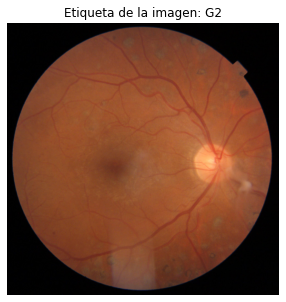

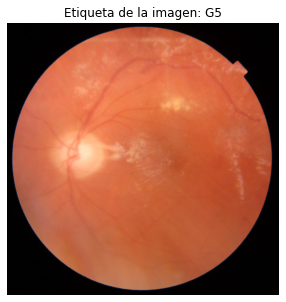

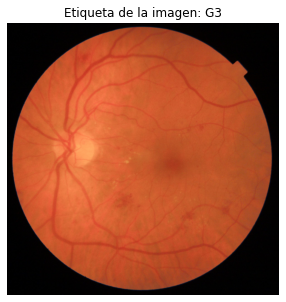

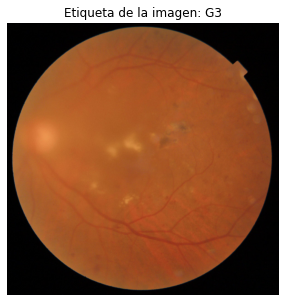

IMÁGENES DEL TEST IPHONE


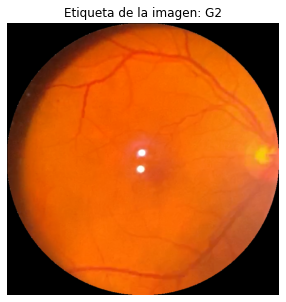

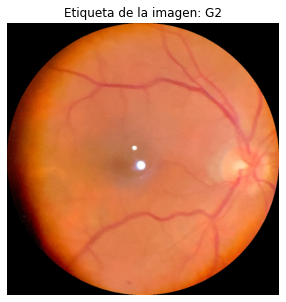

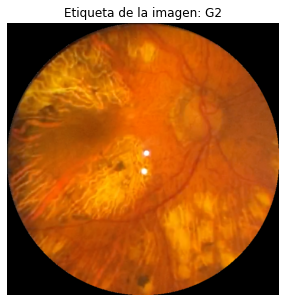

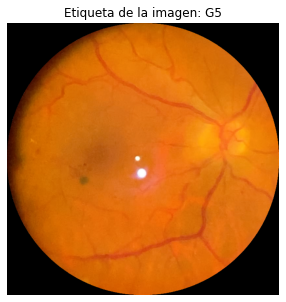

IMÁGENES DEL TEST SAMSUNG


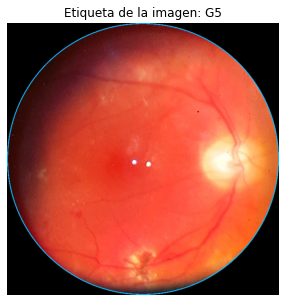

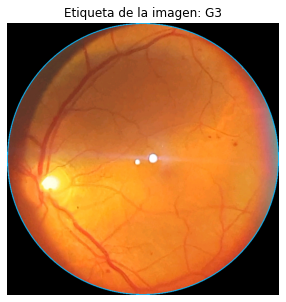

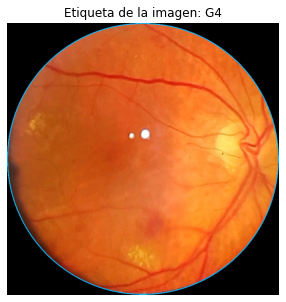

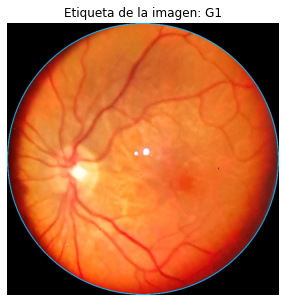

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=394384, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)
Época 1/50 - Accuracy: 0.39823008849557523 - Loss: 0.4276878454483452
Época 2/50 - Accuracy: 0.504424778761062 - Loss: 0.3262300333090588
Época 3/50 - Accuracy: 0.48672566371681414 - Loss: 0.40904889644774717
Época 4/50 - Accuracy: 0.49557522123893805 - Loss: 0.3355523727636422
Época 5/50 - Accuracy: 0.5398230088495575 - Loss: 0.32595987446540226
Época 6/50 - Accuracy: 0.5309734513274337 - Loss: 0.29212346251031995
Época 7/50 - Accuracy: 0.5663716814159292 - Loss: 0.263963165536391
Época 8/50 - Accuracy: 0.6283185840707964 - Loss: 0.22219708687172526
Época 9/50 - Accuracy: 0.7079646017699115 - Loss: 0.1968927419027396
Época 10/50 - Accuracy: 0.7433628318584071 - Loss: 0.1664414231

NameError: name 'guarda_graficas' is not defined

In [1]:
'''
#########################################################################################################################
INFORMACIÓN DEL FICHERO
#########################################################################################################################

Autor: Samuel Lozano Juárez
Fecha: 07/02/2023
Institución: UBU | Grado en Ingeniería de la Salud

Este archivo forma parte del Trabajo de Fin de Grado "Detección del grado de retinopatía mediante redes convolucionales".
El alumno a cargo de este proyecto es el declarado como autor en las líneas anteriores.
Los tutores del proyecto fueron el Dr. Darío Fernández Zoppino y el Dr. Daniel Urda Muñoz.

En el código que se encuentra a continuación voy a crear una primera arquitectura de red neuronal convolucional, así como las demás 
estructuras necesarias para poder entrenar dicha red (como por ejemplo las funciones que permiten cargar las imágenes o generar los 
batches o lotes para el entrenamiento).

La arquitectura del modelo será básica, siguiendo la estructura que se encuentra disponible en la propia página del framework Pytorch:
https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html#pytorch-models

Finalmente se obtendrán las métricas de Accuracy, Balanced Accuracy, F-Score, AUC de la curva ROC y Quadratic Weighted Kappa, tanto para
imágenes de iPhone como imágenes de Samsung. De esta manera podremos evaluar el rendimiento de la red en comparación con un clínico.
'''


#importamos los paquetes necesarios
import torch #contiene todas las funciones de PyTorch
import torch.nn as nn #contiene la clase padre de todos los modelos (nn.Module)
import torch.nn.functional as F #esencial para la función de activación 
import torchvision #fundamental para la importación de imágenes
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
#importamos también matplotlib.pyplot y numpy para la visualización de las imágenes
import matplotlib.pyplot as plt
import numpy as np
import os

#importamos los paquetes necesarios para el cálculo de las métricas
import sklearn
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
import seaborn as sns



In [2]:
#importamos la función para guardar las gráficas
from modules.CNN_utilities import guarda_graficas



#e importamos el paquete para el cálculo del tiempo de ejecución
import time

#es necesario incluir la siguiente línea para que no se produzcan errores en la representación de las imágenes (entran en conflicto algunos ficheros de matplotlib con los de PyTorch sino)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#establecemos el tamaño del batch, la escala de las imágenes y el número de épocas de entrenamiento
batch = 4
escala = 640
epocas = 50

#a continuación definimos la operación que permitirá transformar las imágenes del repositorio en Tensores que puedan ser empleados por PyTorch
transform = transforms.Compose(
    [transforms.ToTensor(), #transforma la imagen de formato PIL a formato tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #normaliza el tensor para que la media de sus valores sea 0 y su desviación estándar 0.5
     transforms.Resize((escala, escala))]) #redimensionamos las imágenes

#a continuación cargamos el conjunto de imágenes de train (OCT) y los dos de test (iPhone y Samsung)
OCT = ImageFolder(root = 'Datos/Classified Data/Images/OCT', transform = transform)
print(f'Tamaño del conjunto de datos de train: {len(OCT)}')

Samsung = ImageFolder(root = 'Datos/Classified Data/Images/Samsung', transform = transform)
print(f'Tamaño del conjunto de datos de test de Samsung: {len(Samsung)}')

iPhone = ImageFolder(root = 'Datos/Classified Data/Images/iPhone', transform = transform)
print(f'Tamaño del conjunto de datos de test de iPhone: {len(iPhone)}')

#establecemos una lista con el nombre de las etiquetas
classes = OCT.classes

#y definimos también las funciones que van a ir cargando las imágenes en el modelo
train_loader = DataLoader(
    dataset = OCT,
    batch_size = 4, #establecemos un tamaño de lote (batch_size) de 4, ya que son pocas imágenes y podemos permitírnoslo
    shuffle = True, #indicamos que mezcle las imágenes
    num_workers = 2 #genera subprocesos para cargar los datos y así liberamos el proceso main
)

test_S_loader = DataLoader(
    dataset = Samsung,
    batch_size = 4, #establecemos un tamaño de lote (batch_size) de 10, ya que son pocas imágenes y podemos permitírnoslo
    shuffle = True, #indicamos que mezcle las imágenes
    num_workers = 2 #genera subprocesos para cargar los datos y así liberamos el proceso main
)

test_i_loader = DataLoader(
    dataset = iPhone,
    batch_size = 4, #establecemos un tamaño de lote (batch_size) de 10, ya que son pocas imágenes y podemos permitírnoslo
    shuffle = True, #indicamos que mezcle las imágenes
    num_workers = 2 #genera subprocesos para cargar los datos y así liberamos el proceso main
)

#para comprobar que los loaders funcionan correctamente vamos a probar a cargar las imágenes y mostrarlas
#convertimos el train_loader a iterador, para poder así coger un batch
#el batch está compuesto por una tupla de 2 elementos: las imágenes (tensores en este caso) y las etiquetas asociadas
images, labels = next(iter(train_loader))

#mostramos las imágenes y las labels asociadas
print('IMÁGENES DEL CONJUNTO DE TRAIN')
for i,j in zip(images,labels):
    plt.figure(figsize = (5,5))
    plt.axis('off')
    plt.title(f'Etiqueta de la imagen: {classes[j]}')
    plt.imshow(np.transpose((i/2+0.5).numpy(), (1,2,0)))
    plt.show()

#hacemos el mismo proceso con las imágenes de test de iPhone
images, labels = next(iter(test_i_loader))

#mostramos las imágenes y las labels asociadas
print('IMÁGENES DEL TEST IPHONE')
for i,j in zip(images,labels):
    plt.figure(figsize = (5,5))
    plt.axis('off')
    plt.title(f'Etiqueta de la imagen: {classes[j]}')
    plt.imshow(np.transpose((i/2+0.5).numpy(), (1,2,0)))
    plt.show()

#y con el conjunto de imágenes de test de Samsung
images, labels = next(iter(test_S_loader))

#mostramos las imágenes y las labels asociadas
print('IMÁGENES DEL TEST SAMSUNG')
for i,j in zip(images,labels):
    plt.figure(figsize = (5,5))
    plt.axis('off')
    plt.title(f'Etiqueta de la imagen: {classes[j]}')
    plt.imshow(np.transpose((i/2+0.5).numpy(), (1,2,0)))
    plt.show()

#una vez que hemos comprobado que las funciones de carga funcionan correctamente ya podemos definir el modelo
#los modelos se definen como clases que heredan todos ellos de un mismo padre: nn.Module
#las clases contienen 2 funciones básicas: __init__() y forward()
class CNN(nn.Module):
    
    def __init__(self):
        #esta función sobreescribe la función init() del padre
        super(CNN,self).__init__()
        #definimos todas las capas que van a constituir el modelo
        #una primera capa convolucional
        self.conv1 = nn.Conv2d(
            in_channels = 3, #3 canales de entrada porque las imágenes son a color
            out_channels = 6, #se trata del número de salidas de la capa. Es el número de kernels de la capa convolucional
            kernel_size = 5, #suele tratarse de un número impar
            stride = 1, #cantidad píxeles que se desplaza el filtro sobre la imagen
            padding = 0, #cantidad de relleno que se va a aplicar sobre los bordes de la imagen
        )
        #una segunda capa convolucional
        self.conv2 = nn.Conv2d(
            in_channels = 6, #6 canales de entrada porque es el número de salidas de la capa anterior
            out_channels = 16, #se trata del número de salidas de la capa. Es el número de kernels de la capa convolucional
            kernel_size = 5, #suele tratarse de un número impar
            stride = 1, #cantidad píxeles que se desplaza el filtro sobre la imagen
            padding = 0, #cantidad de relleno que se va a aplicar sobre los bordes de la imagen
        )
        
        #una primera capa fully-connected (red neuronal propiamente dicha)
        self.fc1 = nn.Linear(
            in_features = 16*157*157, #número de parámetros de entrada de la red (los valores se obtienen experimentalmente)
            out_features = 120 #número de neuronas de salida
        )
        
        #una segunda fully-connected
        self.fc2 = nn.Linear(120, 84)
        
        #y una tercera. Nótese que el número de neuronas de salida de la última fully-connected ha de coincidir con el número de clases
        self.fc3 = nn.Linear(84,5)
        
    def forward(self,x):
        #en esta función es donde tiene lugar la computación (y la función invocada por defecto al ejecutar la red)
        #primero aplicamos la función ReLU a la capa convolucional, que simplifica los datos. 
        #ReLU Interpreta los valores positivos como son, y los negativos los torna 0, permitiendo acelerar el entrenamiento
        #al resultado le aplicamos MaxPooling que reduce las dimensiones de los datos, seleccionando el valor máximo del kernel.
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size = 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size = 2)
        #aplanamos la salida, hasta convertirla de forma matricial a forma vectorial (sería la capa flatten)
        x = x.view(-1,self.num_flat_features(x))#usamos una función propia de la clase para obtener el número de características
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #no incluimos una capa de LogSoft, que convierte el output en probabilidad, ya que la función loss que usaremos incluye esta funcionalidad
        return x
    
    def num_flat_features(self,x):
        #por último definimos la función que permite obtener el número de características de los tensores
        size = x.size()[1:] #seleccionamos todas las dimensiones expcepto la primera (que son los batches)
        num_features = 1
        #va iterando y calcula el número de características de los datos (x)
        for s in size:
            num_features*=s
        return num_features

#una vez definida la clase generamos una instancia de la misma
cnn = CNN()
#y mostramos por pantalla sus secciones
print(cnn)

#a continuación debemos entrenar el modelo, para ello es necesario definir una función loss que evalúa la desviación entre las predicciones y los valores reales
#definimos como loss la función de tipo cross entropy 
criterion = nn.CrossEntropyLoss() 

#y una función optimizadora que modificará los pesos de la red para tratar de mejorar su rendimiento
#en este caso el optimizador será la función Adam (ampliamente utilizada)
optimizer = torch.optim.Adam(params = cnn.parameters(), #los parámetros son los pesos que deberá ir actualizando el optimizador
                             lr = 0.001) #dejamos el valor de learning rate por defecto (0.001)

#definimos 2 listas en las que almacenaremos los valores de accuracy y loss de cada época para poder graficarlo posteriormente
acc_graph = []
loss_graph = []
#capturamos el tiempo antes de comenzar el entrenamiento
inicio = time.time()
#para entrenar el modelo vamos a iterar el número de épocas determinadas, calculando el valor de loss y accuracy para cada época
for epoch in range(epocas):
    #establecemos el número de predicciones correctas inicial a 0
    correct = 0
    #y el acumulador de loss a 0.0
    train_loss = 0.0
    #y cargamos las imágenes de entrenamiento y sus etiquetas usando la estructura Loader previamente creada
    for i, data in enumerate(train_loader):
        inputs, labels = data
        #establecemos a 0 los parámetros del modelo
        optimizer.zero_grad()
        #generamos las predicciones de los inputs
        outputs = cnn(inputs)
        #calculamos el loss, la desviación de las predicciones con respecto a las etiquetas
        loss = criterion(outputs, labels)
        #propagamos hacia atrás el valor loss
        loss.backward()
        #y modificamos los pesos en función del loss y la función optimizer
        optimizer.step()
        #actualizamos el número de predicciones correctas
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        #añadimos el valor de loss al acumulador train_loss
        train_loss += loss.item()
    
    #una vez finalizada la época (que recorre todo el conjunto de imágenes) mostramos el valor del loss y del accuracy
    print(f'Época {epoch +1}/{epocas} - Accuracy: {correct/len(OCT)} - Loss: {train_loss/len(OCT)}')
    #añadimos los valores a la lista correspondiente
    loss_graph.append(train_loss/len(OCT))
    acc_graph.append(correct/len(OCT))

#y volvemos a capturar el tiempo una vez finalizado el entrenamiento
fin = time.time()

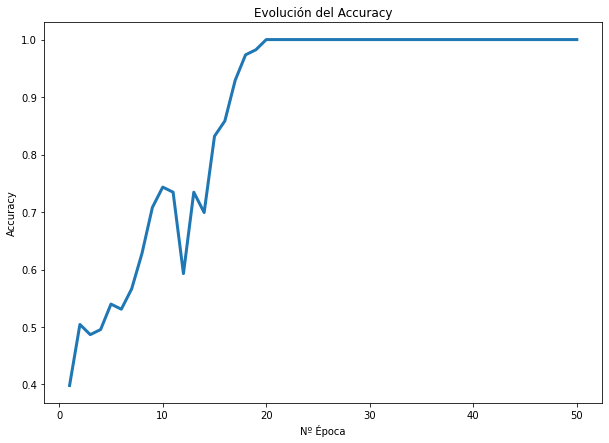

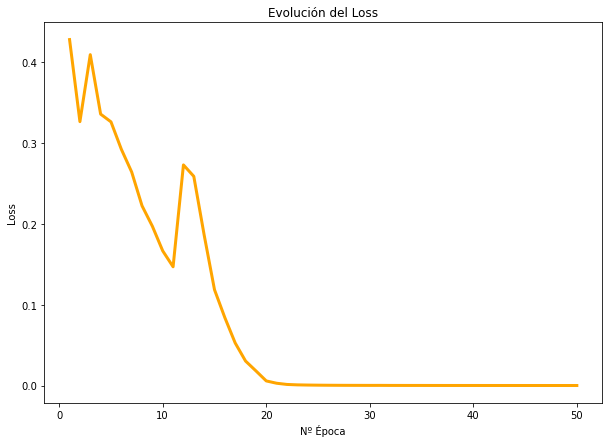

El tiempo de entrenamiento del modelo fue de 28.803664847215018 minutos.
AxesSubplot(0.125,0.125;0.775x0.755)
El valor de accuracy del modelo con imágenes de iphone es: 0.2828282828282828
El valor de balanced accuracy del modelo con imágenes de iphone es: 0.23356643356643358
El valor de F-score del modelo con imágenes de iphone es: 0.2681861348528015
El valor de Kappa del modelo con imágenes de iphone es: 0.008183998871172604
El valor de AUC del modelo con imágenes de iphone es: 0.47878602168258305
AxesSubplot(0.125,0.125;0.775x0.755)
El valor de accuracy del modelo con imágenes de samsung es: 0.3655913978494624
El valor de balanced accuracy del modelo con imágenes de samsung es: 0.33389057750759876
El valor de F-score del modelo con imágenes de samsung es: 0.36167809175399307
El valor de Kappa del modelo con imágenes de samsung es: 0.08868958644743408
El valor de AUC del modelo con imágenes de samsung es: 0.5929553018933638


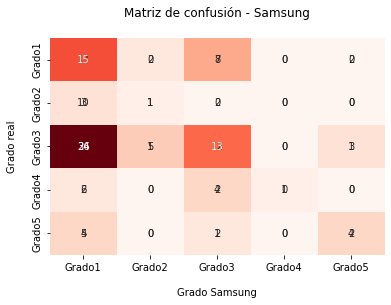

In [3]:
#guardamos las gráficas de entrenamiento
guarda_graficas('OCT','No','No','No','RGB','Basica',2,1.0,'120/84',acc_graph,loss_graph)
    
#a continuación mostramos la evolución temporal del accuracy
plt.figure(figsize = (10,7))
plt.title('Evolución del Accuracy')
plt.xlabel('Nº Época')
plt.ylabel('Accuracy')
plt.plot(range(1,epocas+1),acc_graph, linewidth = 3)
plt.show()

#a continuación mostramos la evolución temporal del loss
plt.figure(figsize = (10,7))
plt.title('Evolución del Loss')
plt.xlabel('Nº Época')
plt.ylabel('Loss')
plt.plot(range(1,epocas+1),loss_graph, color='orange', linewidth = 3)
plt.show()

#por último solo debemos generar las predicciones a partir de la red entrenada
#creamos 2 listas para almacenar las etiquetas reales y las etiquetas predichas y así poder calcular las métricas
y_true_iphone = []
y_pred_iphone = []
#creamos una para almacenar también la salida del modelo, para posteriormente poder calcular AUC
predictions = []
#y definimos una función para convertir esa salida a forma de probabilidad (usando Softmax)
m = nn.Softmax(dim=1)
#es importante activar torch.no_grad() para que la red no entrene al pasarle el conjunto de test, no varíen los pesos
with torch.no_grad():
    #recorremos el conjunto de imágenes de test de iPhone
    for data in test_i_loader:
        images, labels = data #cargamos las imágenes y las etiquetas del dataloader
        outputs = cnn(images) #obtenemos las predicciones
        predictions.append(m(outputs).numpy()) #las convertimos a probabilidad mediante Softmax 
        _, predicted = torch.max(outputs.data,1) #y obtenemos las etiquetas o labels predichas a partir de la probabilidad
        y_pred_iphone.append(predicted.numpy()) #añadimos la predicción a la lista de predicciones
        y_true_iphone.append(labels.numpy()) #y añadimos la etiqueta real a la lista de etiquetas reales
#convertimos los datos a formato np.array de una única dimensión        
y_true_iphone = np.concatenate(y_true_iphone)
y_pred_iphone = np.concatenate(y_pred_iphone)
predictions = np.concatenate(predictions)

#antes de calcular y mostrar las métricas, mostramos el tiempo de entrenamiento en minutos
print(f'El tiempo de entrenamiento del modelo fue de {(fin-inicio)/60} minutos.')

#a partir de las predicciones y las labels reales podemos calcular las métricas deseadas
#primero la matriz de confusión
matrix_iphone = confusion_matrix(y_true_iphone, y_pred_iphone)
#usamos el paquete seaborn para mostrar de manera más visual la matriz de confusión
plot = sns.heatmap(matrix_iphone, annot = True, cmap = 'Reds', cbar = False)
#establecemos título
plot.set_title('Matriz de confusión - iPhone\n')
#título de cada eje
plot.set_xlabel('\nGrado Iphone')
plot.set_ylabel('Grado real\n')
#y el significado de cada fila y columna de la matriz
plot.xaxis.set_ticklabels(['Grado1','Grado2','Grado3','Grado4','Grado5'])
plot.yaxis.set_ticklabels(['Grado1','Grado2','Grado3','Grado4','Grado5'])
print(plot)

#calculamos el valor de accuracy
accuracy_iphone = accuracy_score(y_true = y_true_iphone, y_pred = y_pred_iphone)
print(f'El valor de accuracy del modelo con imágenes de iphone es: {accuracy_iphone}')
#el balanced accuracy
bal_acc_iphone = balanced_accuracy_score(y_true = y_true_iphone, y_pred = y_pred_iphone)
print(f'El valor de balanced accuracy del modelo con imágenes de iphone es: {bal_acc_iphone}')
#el F-score
f_score_iphone = f1_score(y_true = y_true_iphone, y_pred = y_pred_iphone,average = 'weighted')
print(f'El valor de F-score del modelo con imágenes de iphone es: {f_score_iphone}')
#calculamos el valor de quadratic weighted kappa
kappa_iphone = cohen_kappa_score(y1 = y_true_iphone, y2 = y_pred_iphone)
print(f'El valor de Kappa del modelo con imágenes de iphone es: {kappa_iphone}')
#y por último calculamos el valor de AUC bajo la curva ROC
auc_iphone = roc_auc_score(y_true = y_true_iphone, y_score = predictions, multi_class = 'ovr')
print(f'El valor de AUC del modelo con imágenes de iphone es: {auc_iphone}')

#vamos a incluir los resultados en el fichero .csv
with open('Resultados.csv','a') as fd:
    fd.write('\n')
    fd.write(f'OCT,No,No,No,RGB,Básica,2,1.0,120/84,iphone,{accuracy_iphone},{bal_acc_iphone},{f_score_iphone},{kappa_iphone},{auc_iphone},{(fin-inicio)/60}')

#realizamos el mismo proceso para las imágenes de Samsung
#creamos 2 listas para almacenar las etiquetas reales y las etiquetas predichas y así poder calcular las métricas
y_true_samsung = []
y_pred_samsung = []
#creamos una para almacenar también la salida del modelo, para posteriormente poder calcular AUC
predictions = []
#y definimos una función para convertir esa salida a forma de probabilidad (usando Softmax)
m = nn.Softmax(dim=1)
#es importante activar torch.no_grad() para que la red no entrene al pasarle el conjunto de test, no varíen los pesos
with torch.no_grad():
    #recorremos el conjunto de imágenes de test de Samsung en este caso 
    for data in test_S_loader:
        images, labels = data #cargamos las imágenes y las etiquetas del dataloader
        outputs = cnn(images) #obtenemos las predicciones
        predictions.append(m(outputs).numpy()) #las convertimos a probabilidad mediante Softmax 
        _, predicted = torch.max(outputs.data,1) #y obtenemos las etiquetas o labels predichas a partir de la probabilidad
        y_pred_samsung.append(predicted.numpy()) #añadimos la predicción a la lista de predicciones
        y_true_samsung.append(labels.numpy()) #y añadimos la etiqueta real a la lista de etiquetas reales
#convertimos los datos a formato np.array de una única dimensión 
y_true_samsung = np.concatenate(y_true_samsung)
y_pred_samsung = np.concatenate(y_pred_samsung)
predictions = np.concatenate(predictions)

#a partir de las predicciones y las labels reales podemos calcular las métricas deseadas
matrix_samsung = confusion_matrix(y_true_samsung, y_pred_samsung)
plot = sns.heatmap(matrix_samsung, annot = True, cmap = 'Reds', cbar = False)
#establecemos título
plot.set_title('Matriz de confusión - Samsung\n')
#título de cada eje
plot.set_xlabel('\nGrado Samsung')
plot.set_ylabel('Grado real\n')
#y el significado de cada fila y columna de la matriz
plot.xaxis.set_ticklabels(['Grado1','Grado2','Grado3','Grado4','Grado5'])
plot.yaxis.set_ticklabels(['Grado1','Grado2','Grado3','Grado4','Grado5'])
print(plot)

#calculamos el valor de accuracy
accuracy_samsung = accuracy_score(y_true = y_true_samsung, y_pred = y_pred_samsung)
print(f'El valor de accuracy del modelo con imágenes de samsung es: {accuracy_samsung}')
#el balanced accuracy
bal_acc_samsung = balanced_accuracy_score(y_true = y_true_samsung, y_pred = y_pred_samsung)
print(f'El valor de balanced accuracy del modelo con imágenes de samsung es: {bal_acc_samsung}')
#el F-score
f_score_samsung = f1_score(y_true = y_true_samsung, y_pred = y_pred_samsung,average = 'weighted')
print(f'El valor de F-score del modelo con imágenes de samsung es: {f_score_samsung}')
#calculamos el valor de quadratic weighted kappa
kappa_samsung = cohen_kappa_score(y1 = y_true_samsung, y2 = y_pred_samsung)
print(f'El valor de Kappa del modelo con imágenes de samsung es: {kappa_samsung}')
#y por último calculamos el valor de AUC bajo la curva ROC
auc_samsung = roc_auc_score(y_true = y_true_samsung, y_score = predictions, multi_class = 'ovr')
print(f'El valor de AUC del modelo con imágenes de samsung es: {auc_samsung}')

#vamos a incluir los resultados en el fichero .csv
with open('Resultados.csv','a') as fd:
    fd.write('\n')
    fd.write(f'OCT,No,No,No,RGB,Básica,2,1.0,120/84,Samsung,{accuracy_samsung},{bal_acc_samsung},{f_score_samsung},{kappa_samsung},{auc_samsung},{(fin-inicio)/60}')

#por último vamos a guardar el modelo, sus pesos y estado actual, por si se quisiera volver a emplear
torch.save(cnn.state_dict(), f'modelos/Basica/OCT_Noval_Noprep_Noinp_RGB.pth')